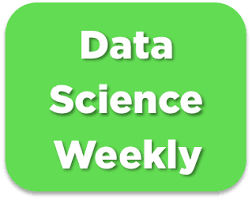

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [298]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# import base estimators
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    f1_score, 
    classification_report,
    ConfusionMatrixDisplay,
    recall_score,
    RocCurveDisplay)

import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
data = pd.read_csv("datas/conversion_data_train_EDA.csv")

In [300]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## Logistic Regression

In [301]:
target = "converted"

x = data.drop(target, axis = 1) 
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [302]:
numerical_columns = x_train.select_dtypes(include=["float", "int"]).columns
categorical_columns = x_train.select_dtypes(include="object").columns

display(x.head())
print("y :", y)
print("numerical_columns :", numerical_columns)
print("categorical_columns :", categorical_columns)

,country,age,new_user,source,total_pages_visited
0,China,22,1,Direct,2
1,UK,21,1,Ads,3
2,Germany,20,0,Seo,14
3,US,23,1,Seo,3
4,US,28,1,Direct,3


y : 0         0
1         0
2         1
3         0
4         0
         ..
283558    0
283559    0
283560    0
283561    0
283562    0
Name: converted, Length: 283563, dtype: int64
numerical_columns : Index(['age', 'new_user', 'total_pages_visited'], dtype='object')
categorical_columns : Index(['country', 'source'], dtype='object')


In [303]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ("encoder", OneHotEncoder(drop="first"))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_columns)
    ])

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

#### Regression Logistique, avec un poids sur la classe 1 qui est déséquilibrée par rapport à la classe 0

In [304]:
lr = LogisticRegression(class_weight={0: 1, 1: 2})

params = {"C": [0.1, 0.3, 0.5, 1]}

grid_search = GridSearchCV(estimator=lr, param_grid=params, scoring="recall")
grid_search.fit(x_train, y_train)

grid_search.best_estimator_

LogisticRegression(C=1, class_weight={0: 1, 1: 2})

In [305]:
scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3)
print("The cross-validated mean score is : ", scores.mean())
print("The standard deviation is : ", scores.std())

The cross-validated mean score is :  0.985047387888743
The standard deviation is :  0.0003318276416078585


J'ai très peu de déviation

In [306]:
y_train_pred = grid_search.best_estimator_.predict(x_train)
y_test_pred = grid_search.best_estimator_.predict(x_test)

In [307]:
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

f1-score on training set :  0.7670349276058465
f1-score on test set :  0.7695675971538041

recall_score on training set :  0.7616516762060507
recall_score on test set :  0.7662125340599455


In [308]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    219512
           1       0.77      0.76      0.77      7338

    accuracy                           0.99    226850
   macro avg       0.88      0.88      0.88    226850
weighted avg       0.98      0.99      0.98    226850



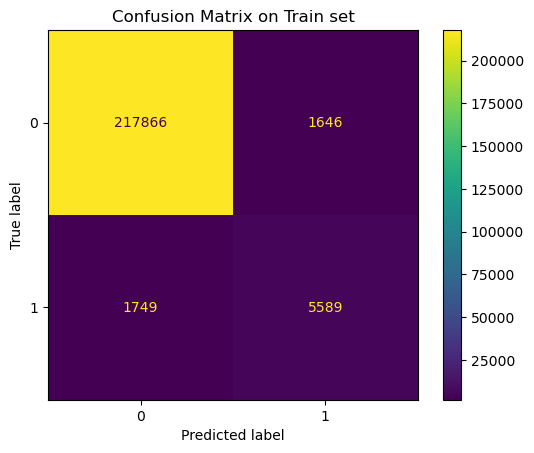

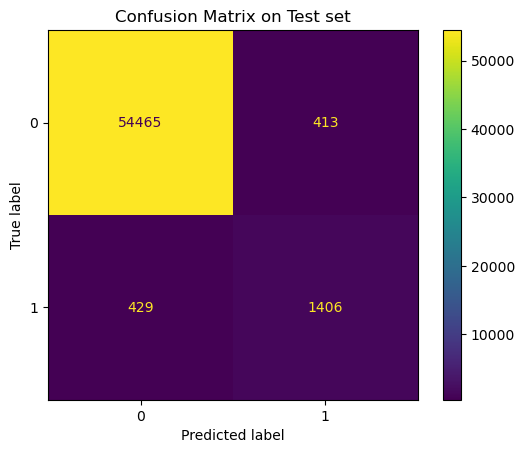

In [309]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_, x_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_, x_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

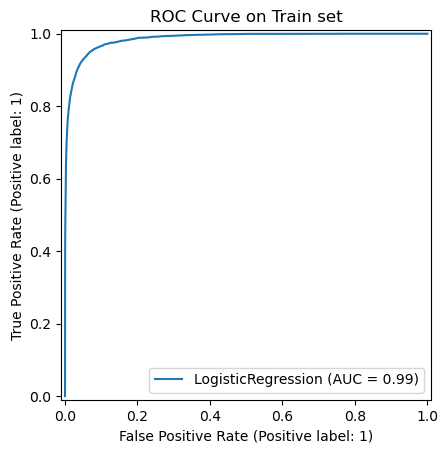

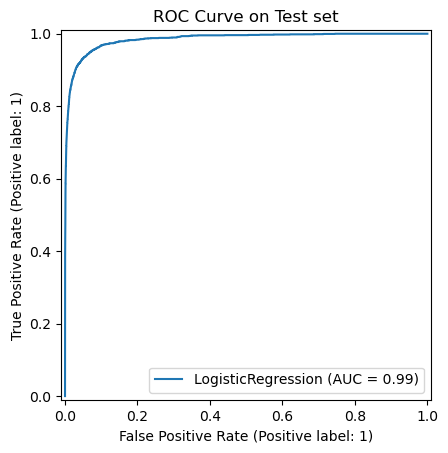

In [310]:
# Visualize ROC curves
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    grid_search.best_estimator_, x_train, y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    grid_search.best_estimator_, x_test, y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

---

Analyse des coefficients

In [311]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = grid_search.best_estimator_.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
age,-0.598704
new_user,-0.784246
total_pages_visited,2.522998
country_Germany,3.661249
country_UK,3.462340
country_US,3.105431
source_Direct,-0.198686
source_Seo,-0.002076


In [312]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

Les colonnes `country` et `total_pages_visited` sont les plus pertinantes à la prédiction, je vais ajouter une colonne pour les concaténer

In [313]:
data["country_total_pages_visited"] = data["total_pages_visited"].astype(str) + data["country"]

target = "converted"

x = data.drop(target, axis = 1) 
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

grid_search.best_estimator_.fit(x_train, y_train)

print(grid_search.best_estimator_)

y_train_pred = grid_search.best_estimator_.predict(x_train)
y_test_pred = grid_search.best_estimator_.predict(x_test)

print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

LogisticRegression(C=1, class_weight={0: 1, 1: 2})
f1-score on training set :  0.7670349276058465
f1-score on test set :  0.7695675971538041

recall_score on training set :  0.7616516762060507
recall_score on test set :  0.7662125340599455


---

## make predictions on X_without_labels

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv("datas/conversion_data_test_EDA.csv")
data_without_labels["country_total_pages_visited"] = data_without_labels["total_pages_visited"].astype(str) + data_without_labels["country"]

x_without_labels = data_without_labels

x_without_labels = preprocessor.transform(x_without_labels)
y_pred_without_label = grid_search.best_estimator_.predict(x_without_labels)

# Read target without labels
y_without_labels = pd.read_csv("datas/conversion_data_test_labels_EDA.csv")

print("f1-score on set without labels : ", f1_score(y_without_labels, y_pred_without_label))
print()
print("recall_score on set without labels : ", recall_score(y_without_labels, y_pred_without_label))

f1-score on set without labels :  0.7603388141504733

recall_score on set without labels :  0.7502458210422812


Sauvegarde des résultats dans un dataframe

In [ ]:
scores_df = pd.DataFrame(columns = ["model", "f1", "recall"])

new_rows = [
    {"model": "lr_concat", "f1": f1_score(y_without_labels, y_pred_without_label), "recall": recall_score(y_without_labels, y_pred_without_label)}
]

scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
scores_df.to_csv("datas/scores.csv", mode="a", header=False, index=False)

C:\Users\janda\AppData\Local\Temp\ipykernel_8320\4006451244.py:7: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,model,f1,recall
0,lr_concat,0.760339,0.750246
